In [1]:
from src.containers.evaluation_container import EvaluationContainer
from src.services.config.config_interface import DirConfig
from src.utils import tqdm_joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import japanize_matplotlib

plt.style.use("ggplot")
dir_config = DirConfig(env='local', exp='eval002_2', debug=False)

In [3]:
def random_evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
        # # random
        if (seed,budget_constraint) not in random_checked:
            # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
            # assign_indexはあとで0にするindex
            assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
            # assginment列に0~6の乱数を代入 -> 1~6では？ 
            sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
            # assgin_indexのidxに0を上書き
            sample_df.loc[assgin_index, 'assginment'] = 0
            # upliftgmv
            random_gmv = 0
            cost = 0
            for t in range(1, 7):
                random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
                random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
                cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[base_config.treatment_name]==t)].sum()
                #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            # 一致しているものの割合 -> つかってない
            # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
            random_rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
            results.append(['random', seed, cost, random_gmv, random_rate])   
            random_checked.add((seed,budget_constraint))

    return results

def evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
            
        # model
        gmv = 0
        cost = 0
        for t in range(1, 7):
            gmv += sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            gmv -= sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()
            # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
        results.append([exp, name, seed, cost, gmv, rate])
    return results

def get_random_result(exp, n_trial):
    num_cores = multiprocessing.cpu_count()
    with tqdm_joblib(n_trial):
        results = Parallel(n_jobs=num_cores)([delayed(random_evaluate)(exp) for _ in range(n_trial)])

    # flatten
    results = [result for result_list in results for result in result_list]

    result_df = pd.DataFrame(results, columns=['name', 'seed', 'cost', 'GMV', 'assign_rate'])
    result_df['cost'] = result_df['cost'].astype(int)
    result_df = result_df.groupby('cost')['GMV'].mean().reset_index()
    result_df['name'] = 'random'

    return result_df

def split_name(name):
    return (
        name.str.split(',', expand=True)
        .iloc[:, 2:]
        .applymap(lambda x: x.split('=')[-1] if isinstance(x, str) else None)
        .astype(float)
    )

In [ ]:
results = []
exps = [f'optimize{i:03}' for i in range(9, 114)]
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(len(exps)):
    results = Parallel(n_jobs=num_cores)([delayed(evaluate)(exp) for exp in exps])

# flatten
results = [item for sublist in results for item in sublist]

result_df = pd.DataFrame(results, columns=['exp', 'name', 'seed', 'cost', 'GMV', 'assign_rate'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['name'] == 'random'
result_df = result_df.sort_values(['random', 'name','cost','seed'])
result_df['sum_GMV'] = result_df.groupby('name')['GMV'].transform('sum')

random_results = get_random_result('optimize001', n_trial=30)

In [7]:
def plot_cluster(container, ax):
    clusters = np.vstack([
        i[-1] for i in container.clusters
    ]).T
    costs = [
        i[-2] for i in container.clusters
    ]

    # 2D plot
    idx = 2
    pca = TruncatedSVD(n_components=2)
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler), ('pca', pca)])

    decomp = pipe.fit_transform(container.uplift_pred)
    decomp = pd.DataFrame(decomp, columns=['x', 'y'])
    decomp['cluster'] = clusters[:, idx]
    decomp['cluster'] = (
        'cluster_' + 
        decomp['cluster'].astype(str) + 
        ' size=' + 
        decomp.groupby('cluster')['x'].transform('count').astype(str)
    )
    sns.scatterplot(data=decomp, x='x', y='y', hue='cluster', palette='tab10', ax=ax)
    
    return ax

def plot_assignment(container, i, ax):
    clusters = np.vstack([
        i[-1] for i in container.clusters
    ]).T
    costs_clusters = [
            i[-2] for i in container.clusters
        ]
    clusters = clusters[:, np.argsort(costs_clusters)]

    assignments = np.vstack([
        i[-1] for i in container.assignments
    ]).T
    costs_assignments = [
            i[-2] for i in container.assignments
        ]
    assignments = assignments[:, np.argsort(costs_assignments)]

    df = pd.DataFrame(
        np.vstack([clusters[:, i], assignments[:, i]]).T,
        columns=['cluster', 'assignment']
    )
    df['assignment']  = (
        df['assignment'].map(container.config.base_config.counpon_config.variant_no_to_coupon_type)
    )

    df.groupby('cluster').value_counts(normalize=True).unstack().plot.bar(stacked=True, ax=ax)
    ax.set_ylabel('count', fontsize=14)
    ax.legend(title='coupon type', fontsize=14)

    return np.sort(costs_clusters)[i]

def plot_cluster_size(container, i, ax):
    clusters = np.vstack([
        i[-1] for i in container.clusters
    ]).T
    df = pd.DataFrame(clusters[:, i], columns=['cluster'])
    df = df['cluster'].value_counts().reset_index()
    df.columns = ['cluster', 'count']

    sns.barplot(data=df, x='cluster', y='count', ax=ax)

    return ax

In [8]:
def plot_cluster_pred_mean(container, i, ax):
    clusters = np.vstack([
        i[-1] for i in container.clusters
    ]).T

    coupon_map = {
        'pred_1': '5% back',
        'pred_2': '5% off',
        'pred_3': '300yen off',
        'pred_4': '10% off',
        'pred_5': '10% back',
        'pred_6': '15% off',
    }

    uplift_pred = container.uplift_pred.copy()
    uplift_pred['cluster'] = clusters[:, i]
    cluster_pred = uplift_pred.groupby('cluster').mean().stack().reset_index().rename(columns={'level_1': 'coupon', 0: 'uplift_pred'})
    cluster_pred['coupon'] = cluster_pred['coupon'].map(coupon_map)

    sns.barplot(data=cluster_pred, x='cluster', y='uplift_pred', hue='coupon', ax=ax)

def plot_cluster_pred_std(container, i, ax):
    clusters = np.vstack([
        i[-1] for i in container.clusters
    ]).T

    coupon_map = {
        'pred_1': '5% back',
        'pred_2': '5% off',
        'pred_3': '300yen off',
        'pred_4': '10% off',
        'pred_5': '10% back',
        'pred_6': '15% off',
    }

    uplift_pred = container.uplift_pred.copy()
    uplift_pred['cluster'] = clusters[:, i]
    cluster_pred = uplift_pred.groupby('cluster').std().stack().reset_index().rename(columns={'level_1': 'coupon', 0: 'uplift_pred'})
    cluster_pred['coupon'] = cluster_pred['coupon'].map(coupon_map)

    sns.barplot(data=cluster_pred, x='cluster', y='uplift_pred', hue='coupon', ax=ax)

In [101]:
exp_ranking = result_df.groupby('exp')['GMV'].sum().sort_values(ascending=False).reset_index()
top_exp_container = EvaluationContainer(exp_ranking.iloc[0]['exp'], debug=False)
top_exp_container.initialize()
bottom_exp_container = EvaluationContainer(exp_ranking.iloc[-1]['exp'], debug=False)
bottom_exp_container.initialize()

[EvaluationContainer 2022-12-23 09:32:00] INFO Setup [EvaluationContainer]
[ConfigService 2022-12-23 09:32:00] INFO Setup [ConfigService]
[ConfigService 2022-12-23 09:32:00] INFO {'root_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research')}
[ConfigService 2022-12-23 09:32:00] INFO {'input_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/input')}
[ConfigService 2022-12-23 09:32:00] INFO {'output_root': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize060')}
[ConfigService 2022-12-23 09:32:00] INFO {'output_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize060/outputs')}
[ConfigService 2022-12-23 09:32:00] INFO {'output_prediction_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize060/predictions')}
[ConfigService 2022-12-23 09:32:00] INFO {'output_model_dir': PosixPath('/Users/tsukuba-yuuki-u

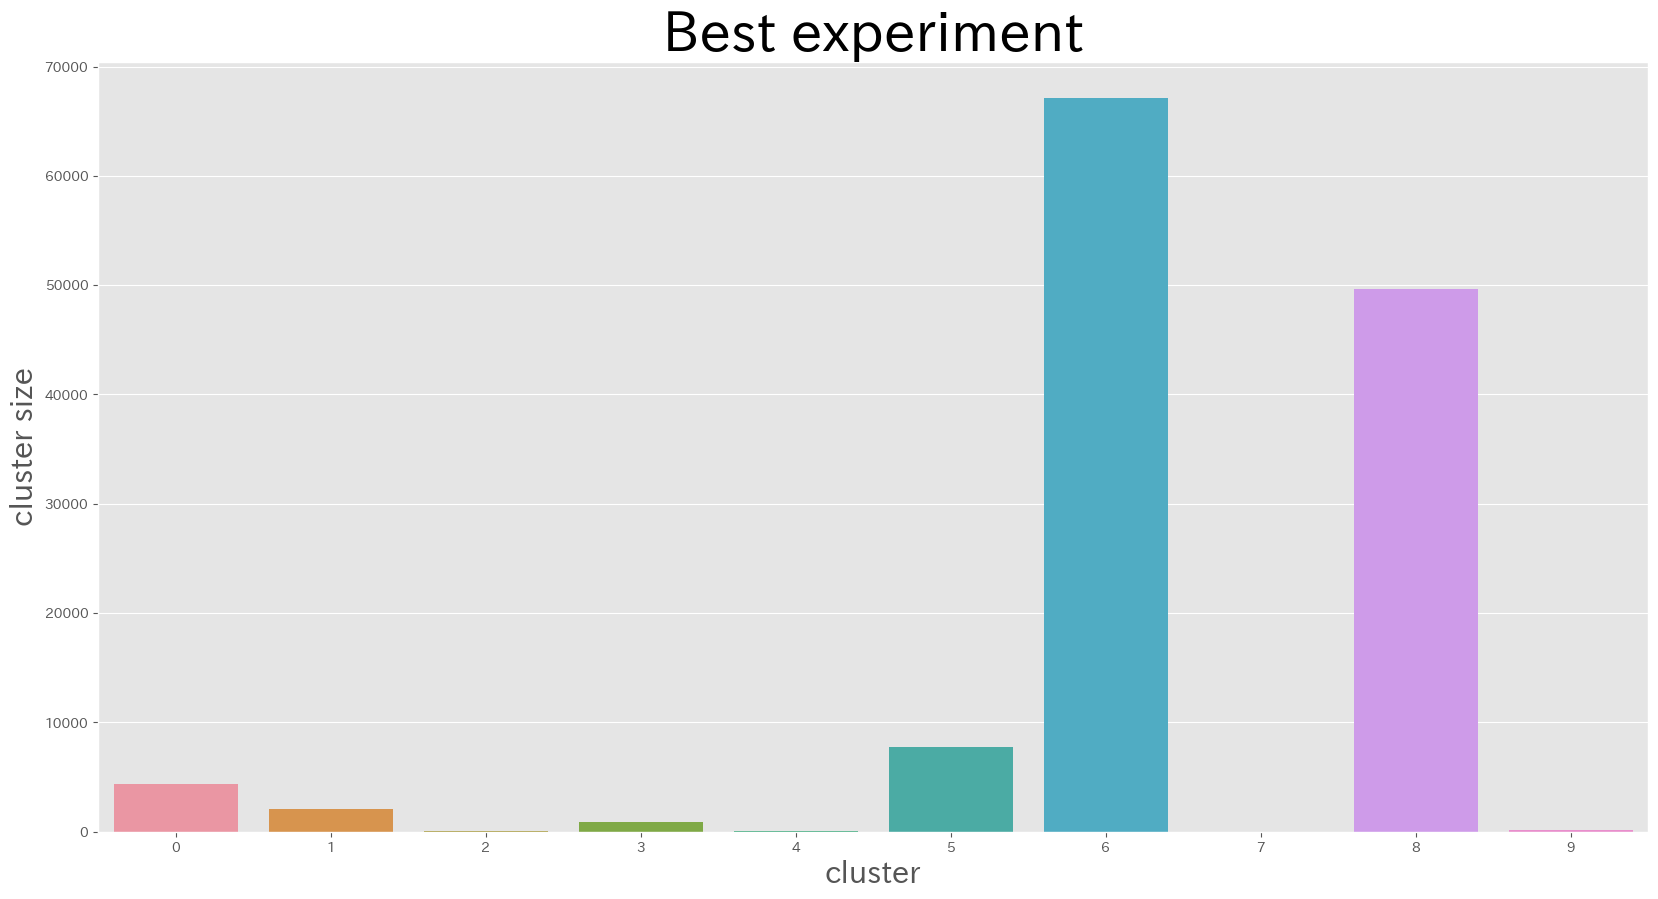

In [103]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
axes = [axes]
plot_cluster_size(top_exp_container, -1, axes[0])
axes[0].set_title('Best experiment', fontsize=40)
axes[0].set_ylabel('cluster size', fontsize=22)
axes[0].set_xlabel('cluster', fontsize=22)

# plot_assignment(bottom_exp_container, -1, axes[1])
# axes[1].set_title('Worst experiment', fontsize=40)
# axes[1].set_ylabel('cluster size', fontsize=22)
# axes[1].set_xlabel('cluster', fontsize=22)

fig.savefig(str(dir_config.output_figure_dir / 'cluster_size.png'))

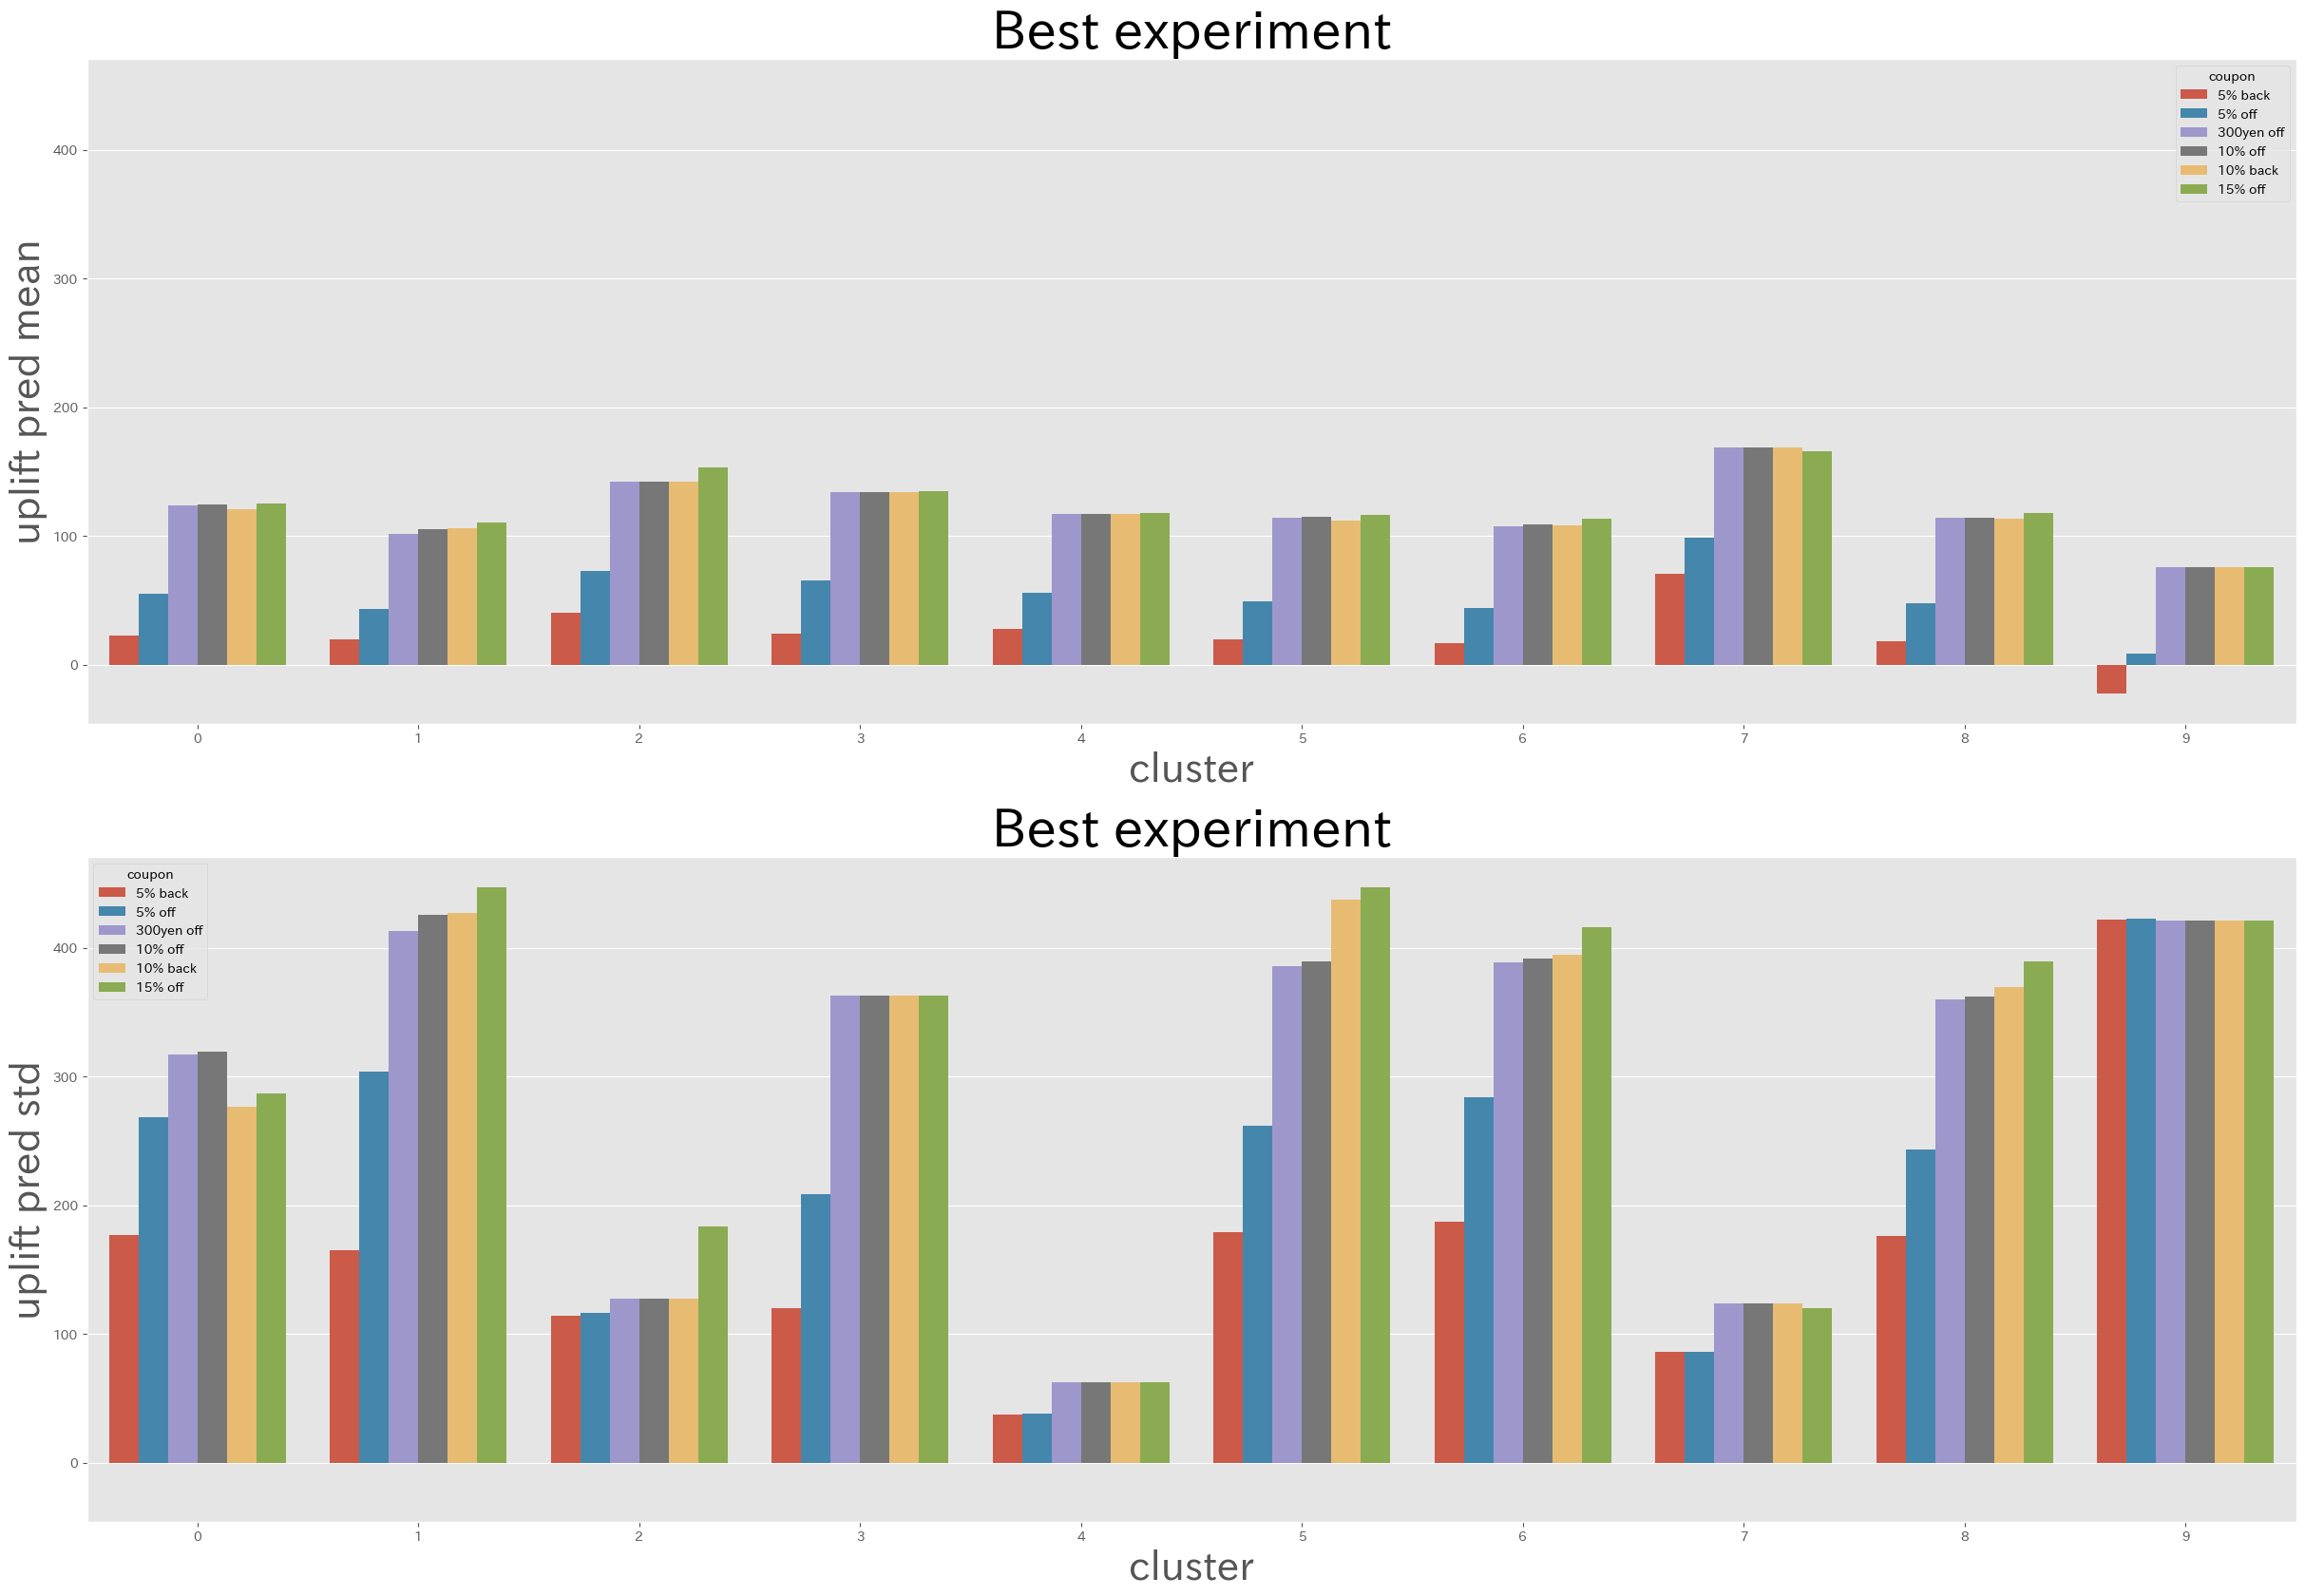

In [105]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20), sharey=True)
axes = np.ravel(axes)
plot_cluster_pred_mean(top_exp_container, -1, axes[0])
axes[0].set_title('Best experiment', fontsize=40)
axes[0].set_ylabel('uplift pred mean', fontsize=30)
axes[0].set_xlabel('cluster', fontsize=30)

# plot_cluster_pred_mean(bottom_exp_container, -1, axes[1])
# axes[1].set_title('Worst experiment', fontsize=40)
# axes[1].set_ylabel('uplift pred mean', fontsize=30)
# axes[1].set_xlabel('cluster', fontsize=30)

plot_cluster_pred_std(top_exp_container, -1, axes[1])
axes[1].set_title('Best experiment', fontsize=40)
axes[1].set_ylabel('uplift pred std', fontsize=30)
axes[1].set_xlabel('cluster', fontsize=30)

# plot_cluster_pred_std(bottom_exp_container, -1, axes[3])
# axes[3].set_title('Worst experiment', fontsize=40)
# axes[3].set_ylabel('uplift pred std', fontsize=30)
# axes[3].set_xlabel('cluster', fontsize=30)

fig.savefig(str(dir_config.output_figure_dir / 'cluster_pred.png'))

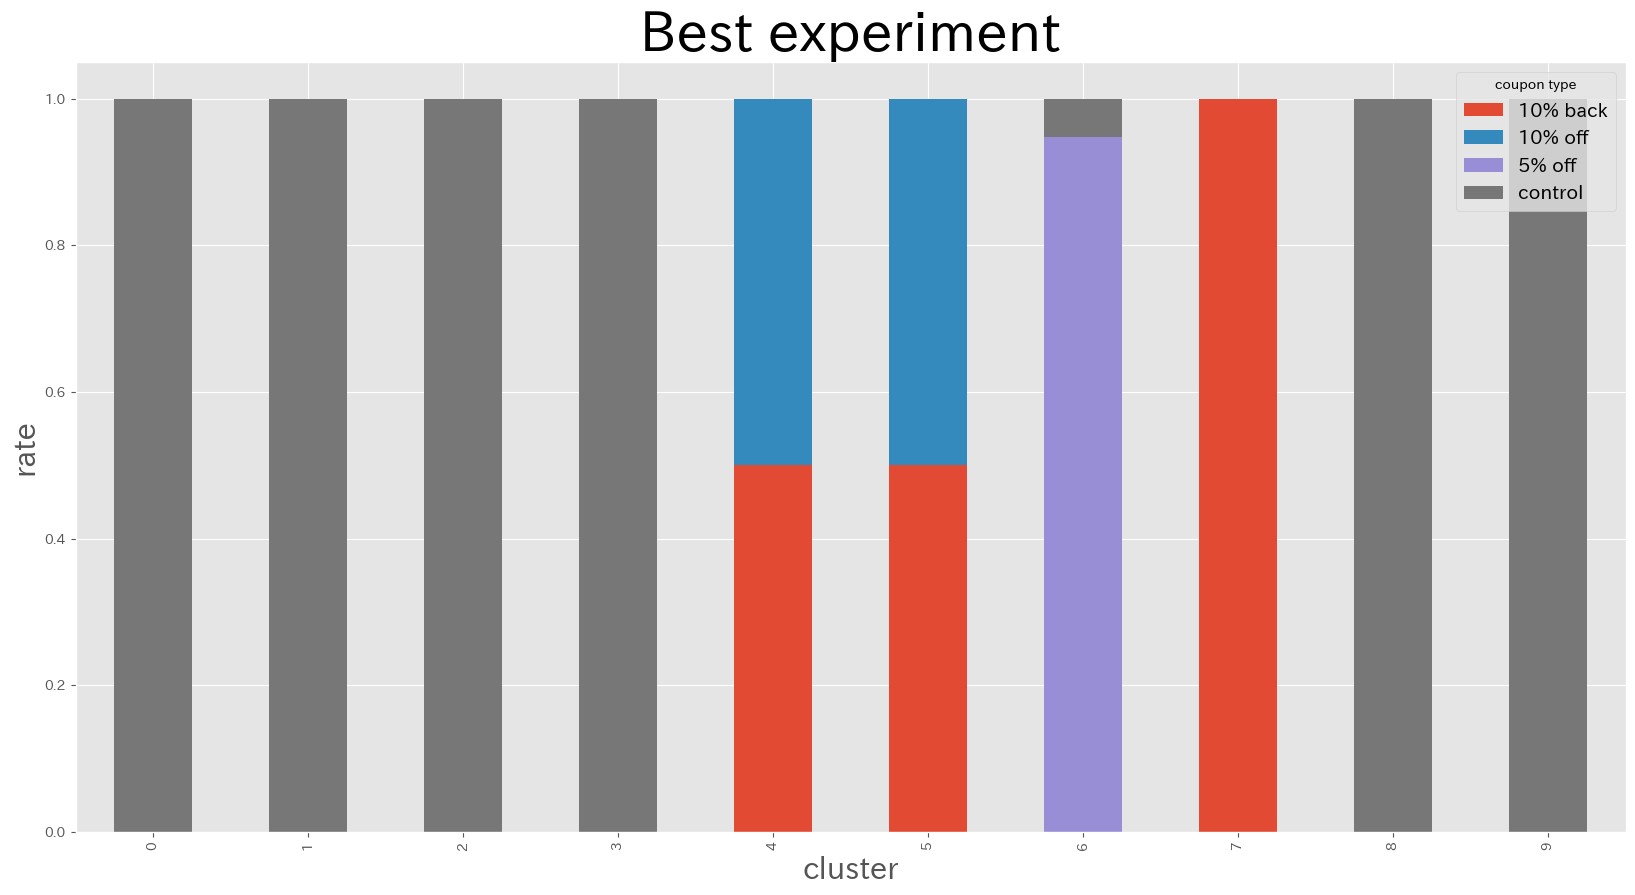

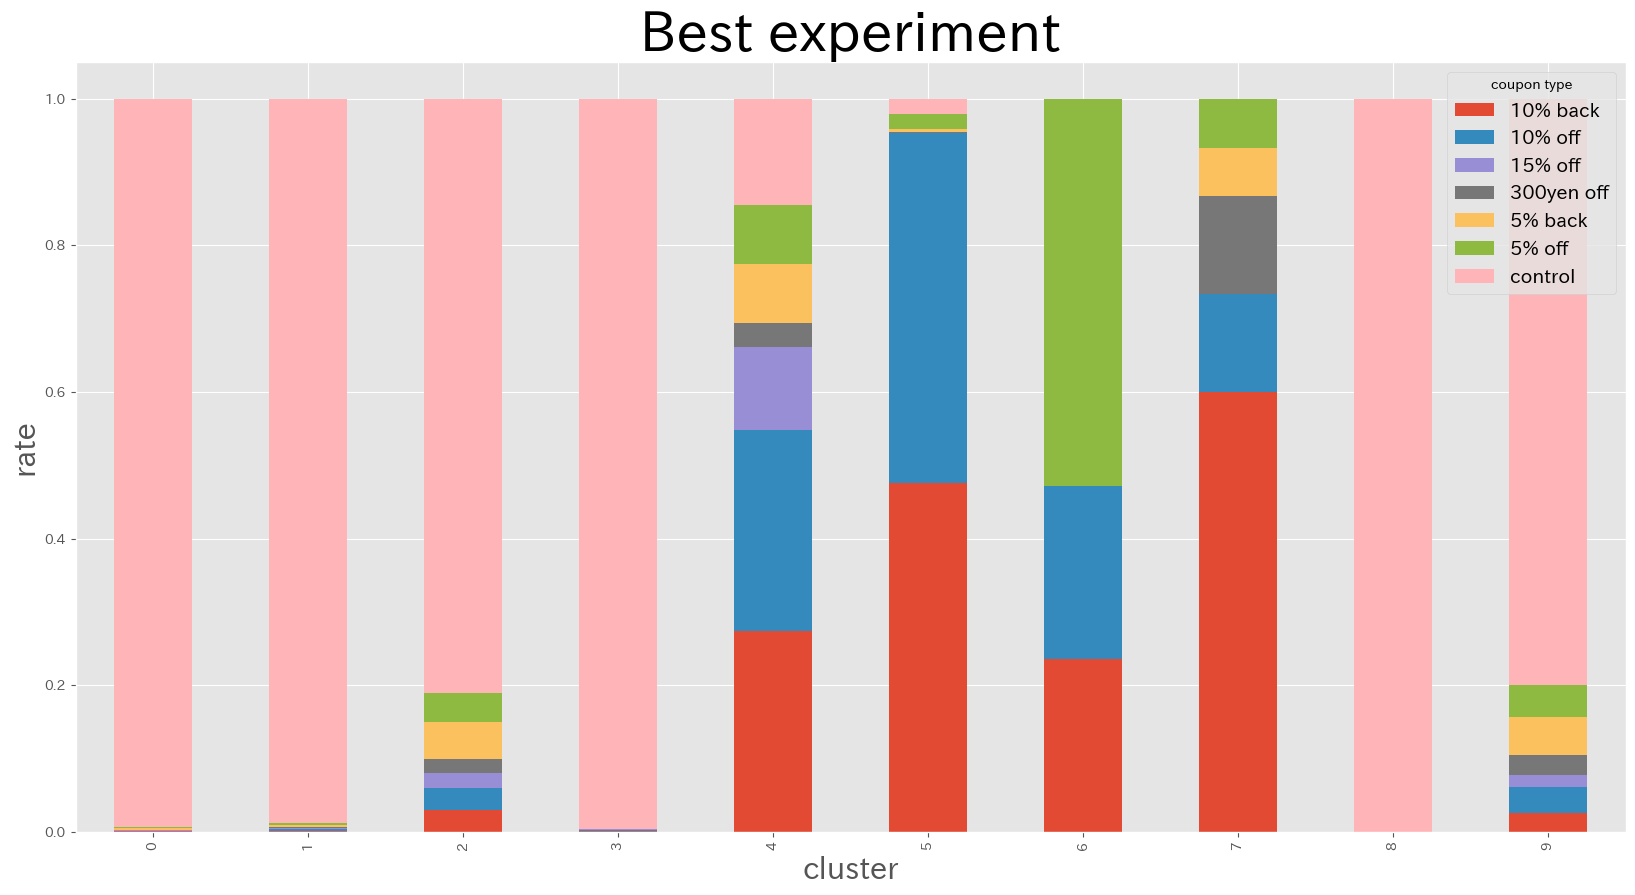

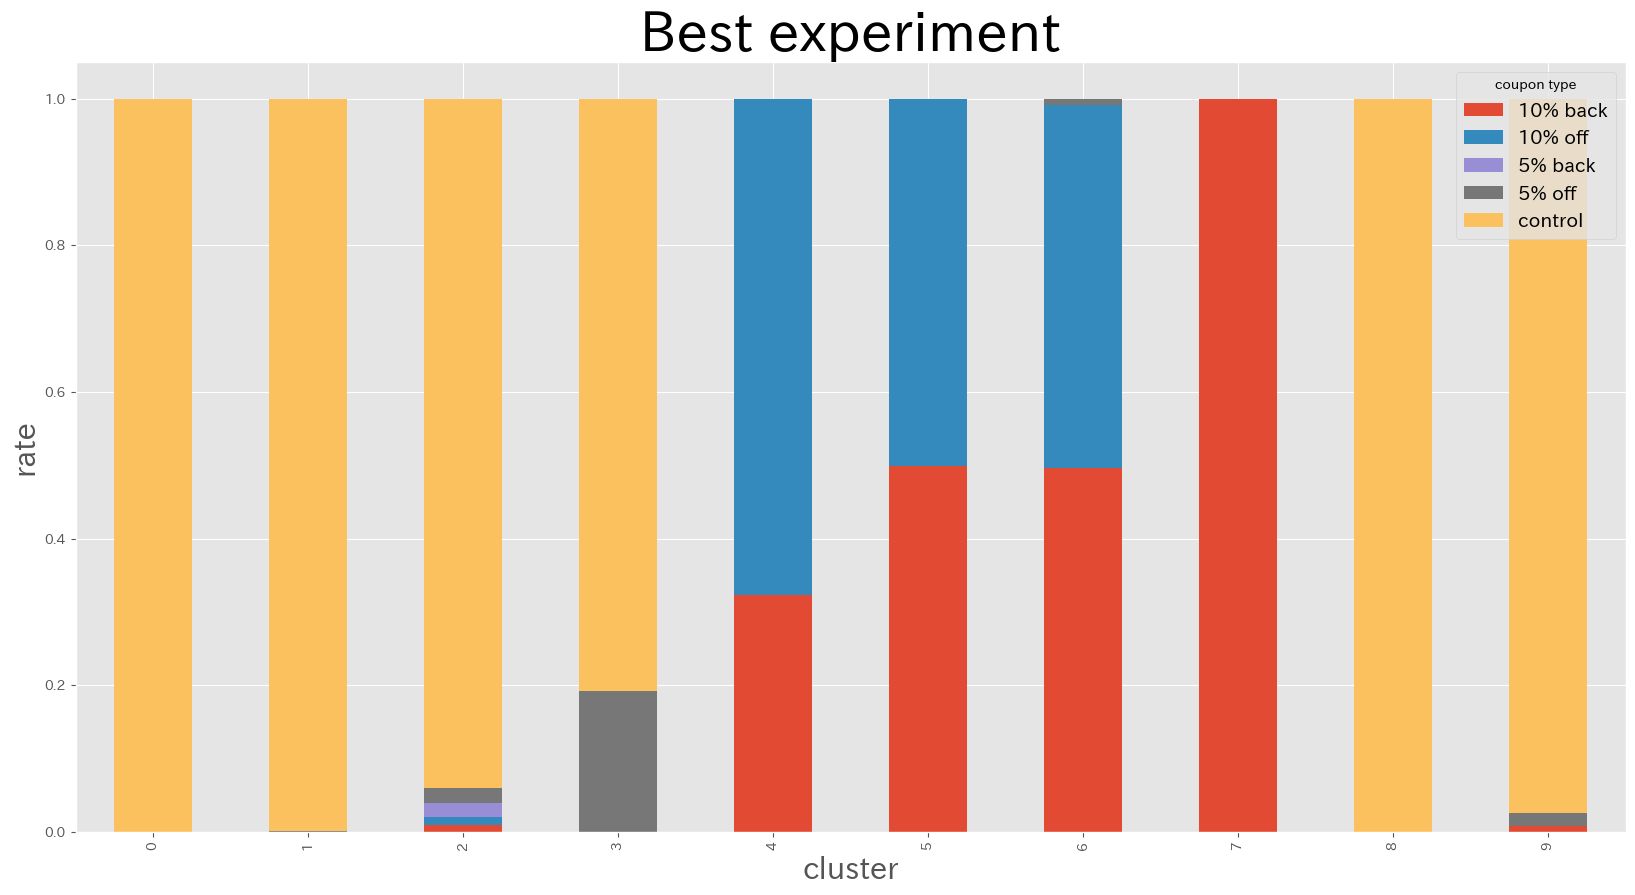

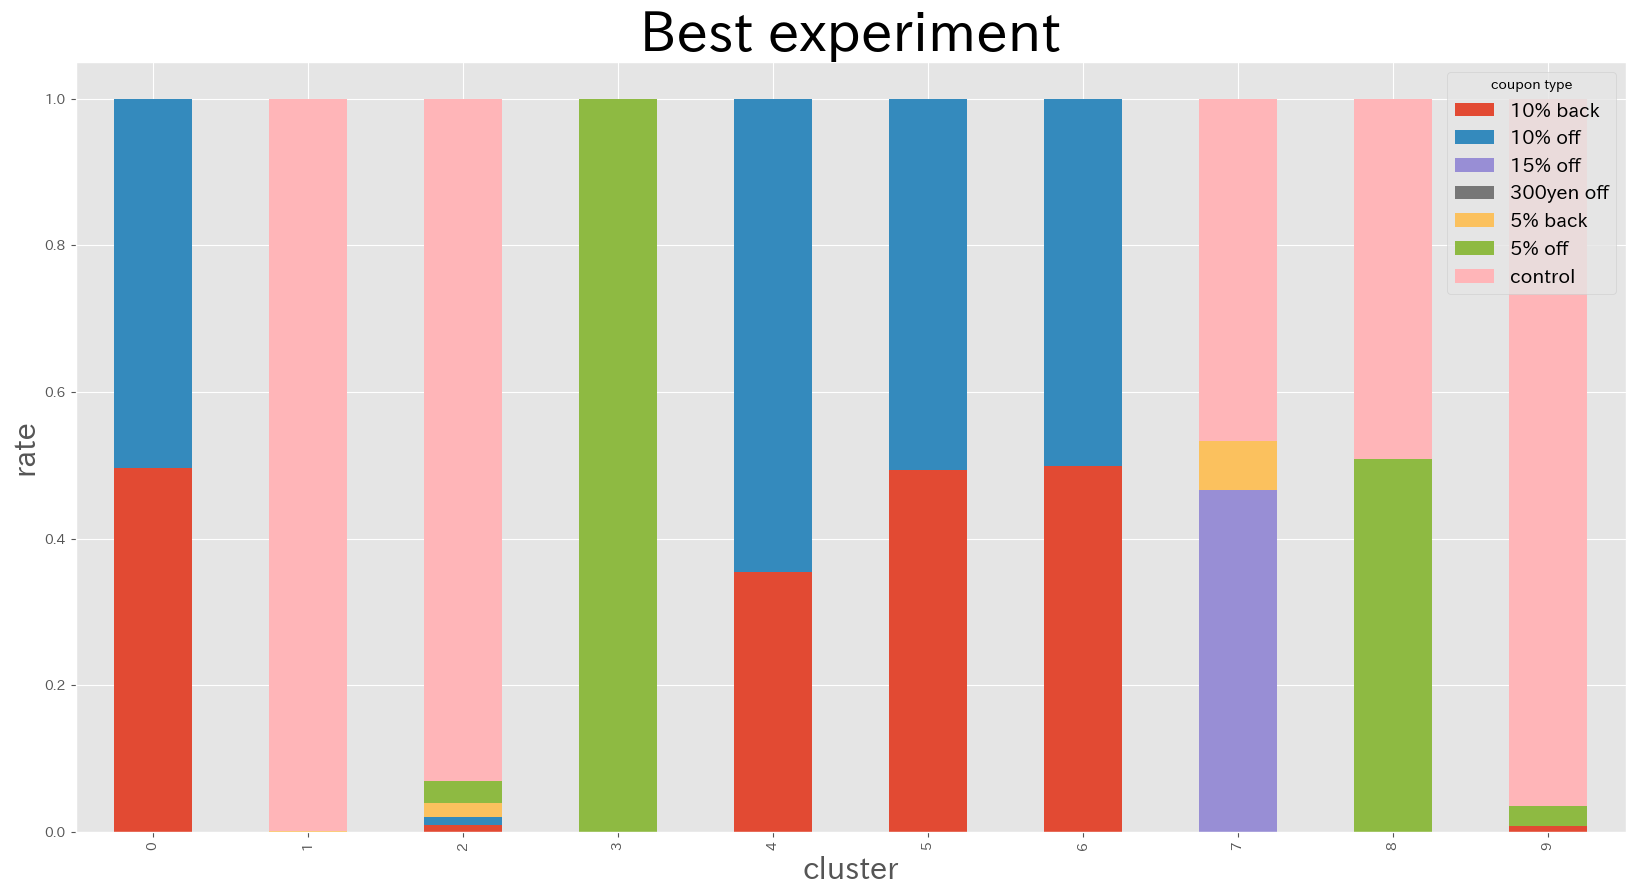

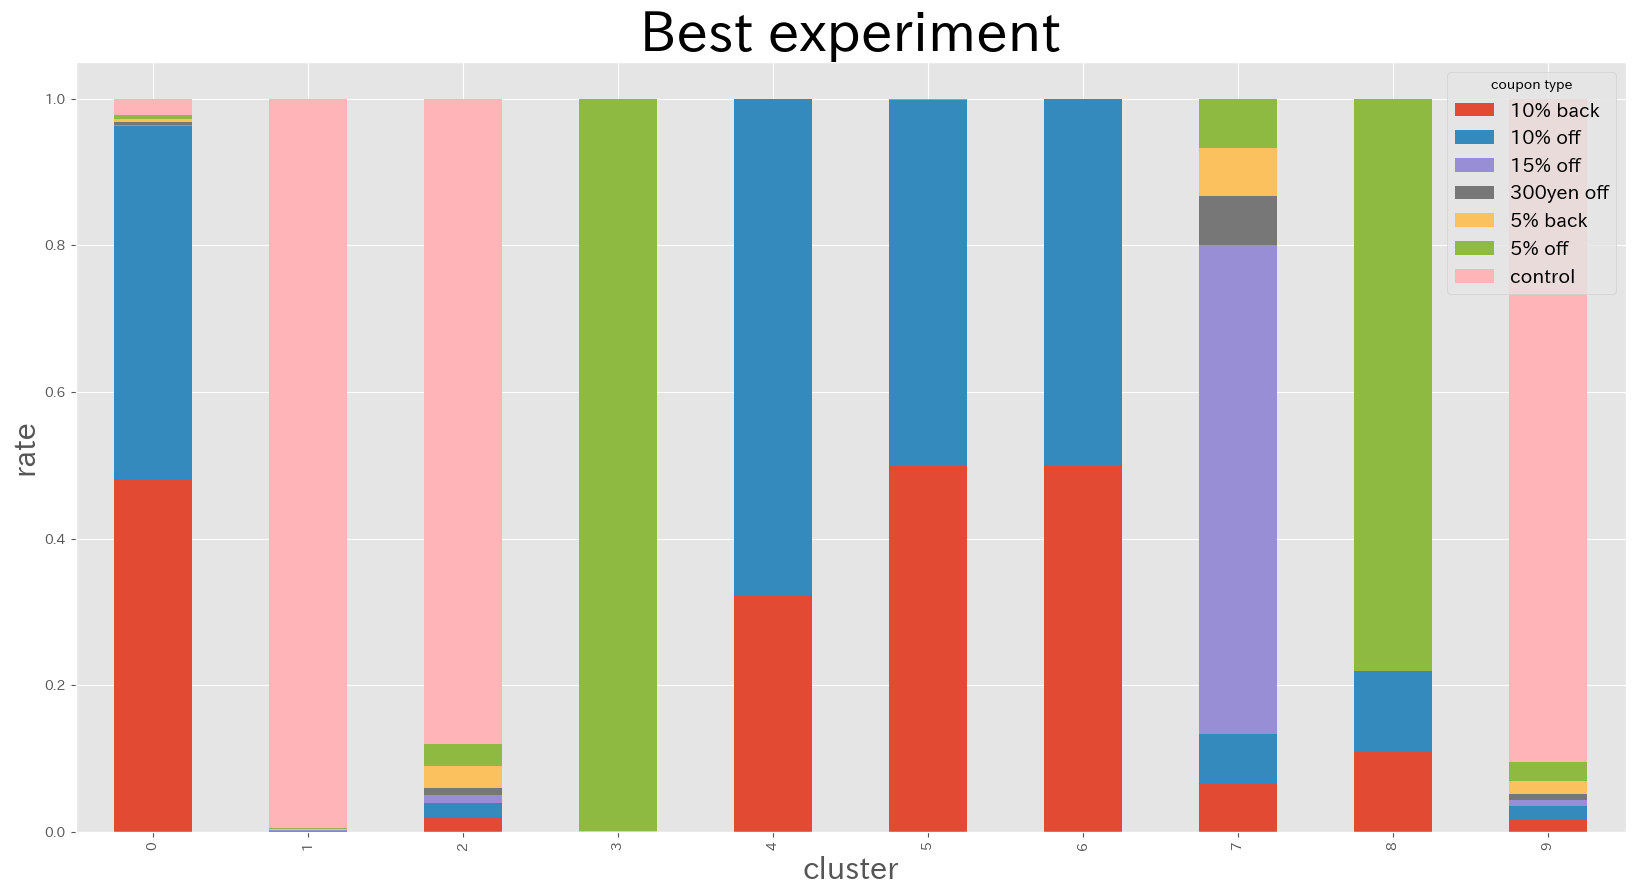

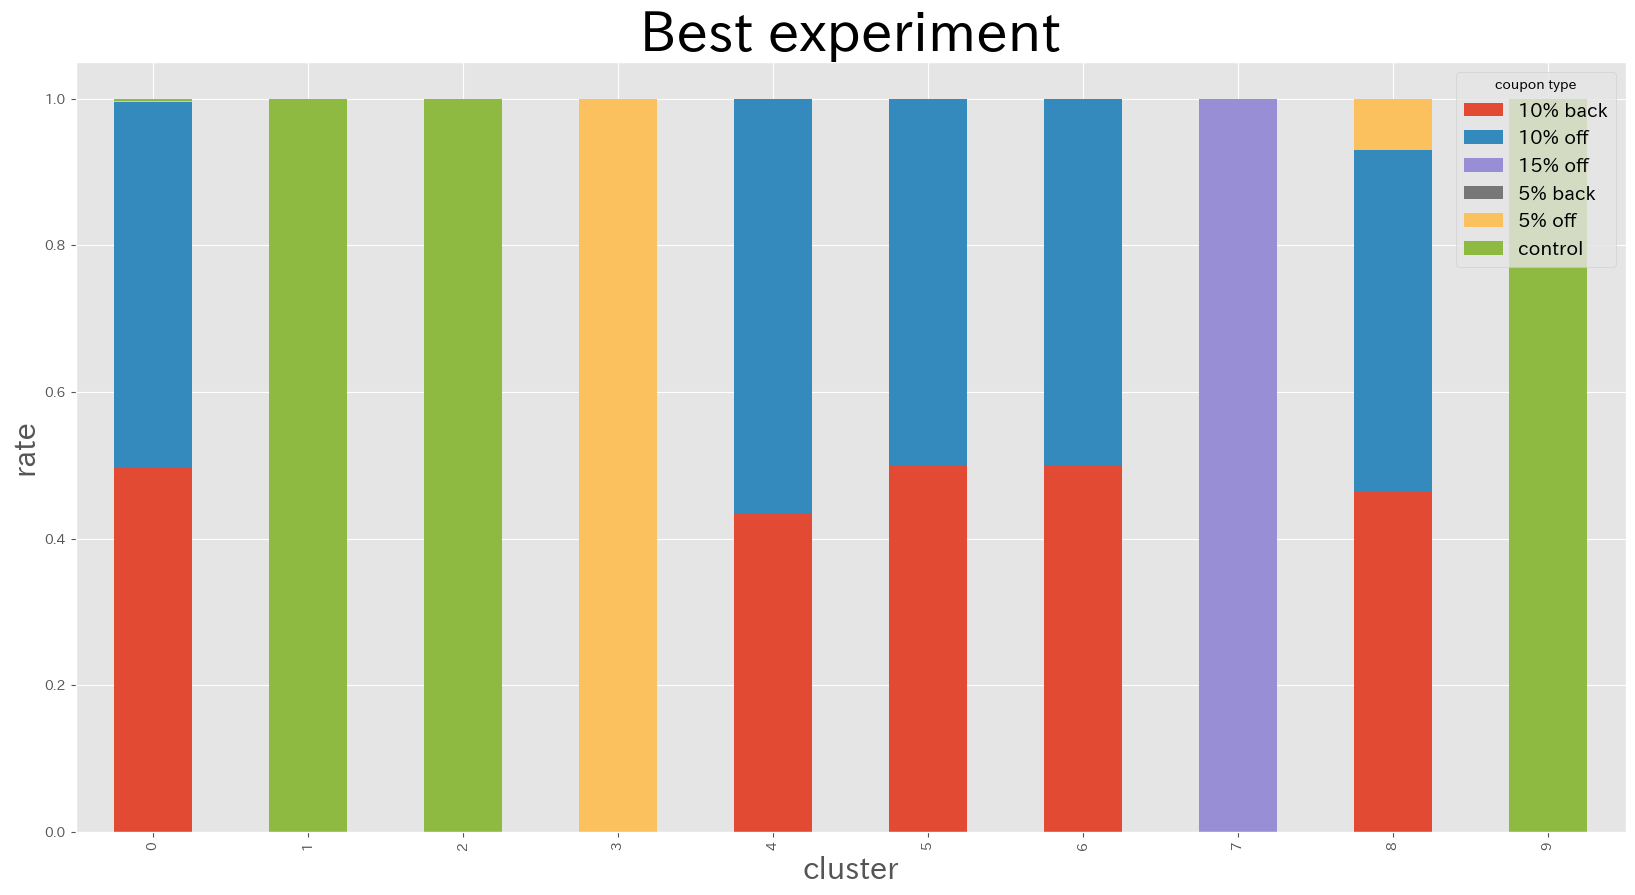

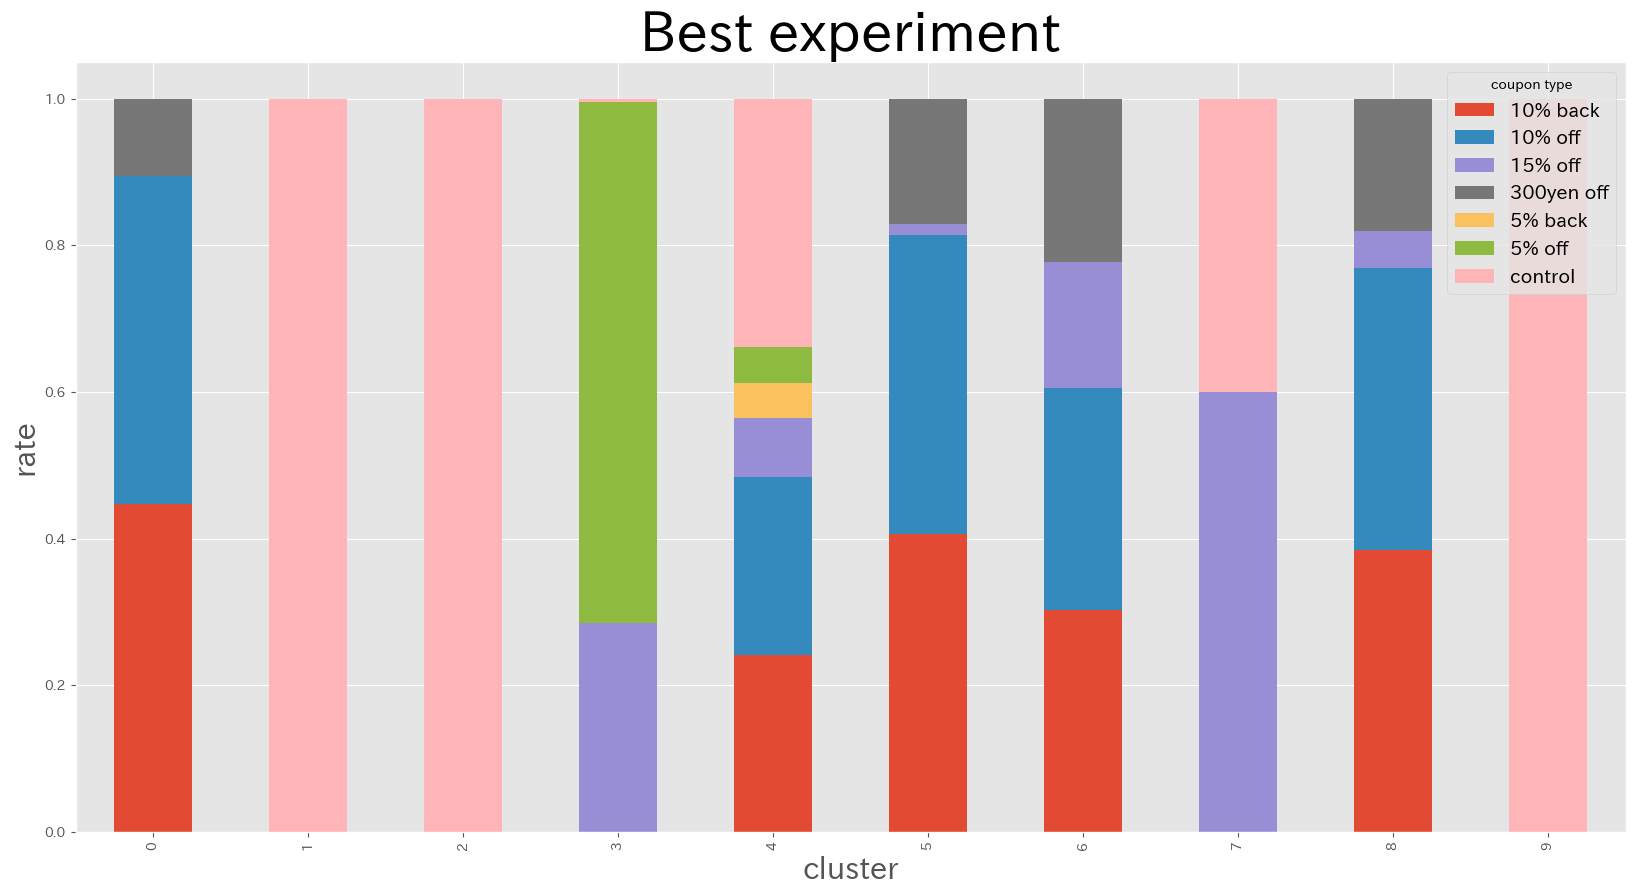

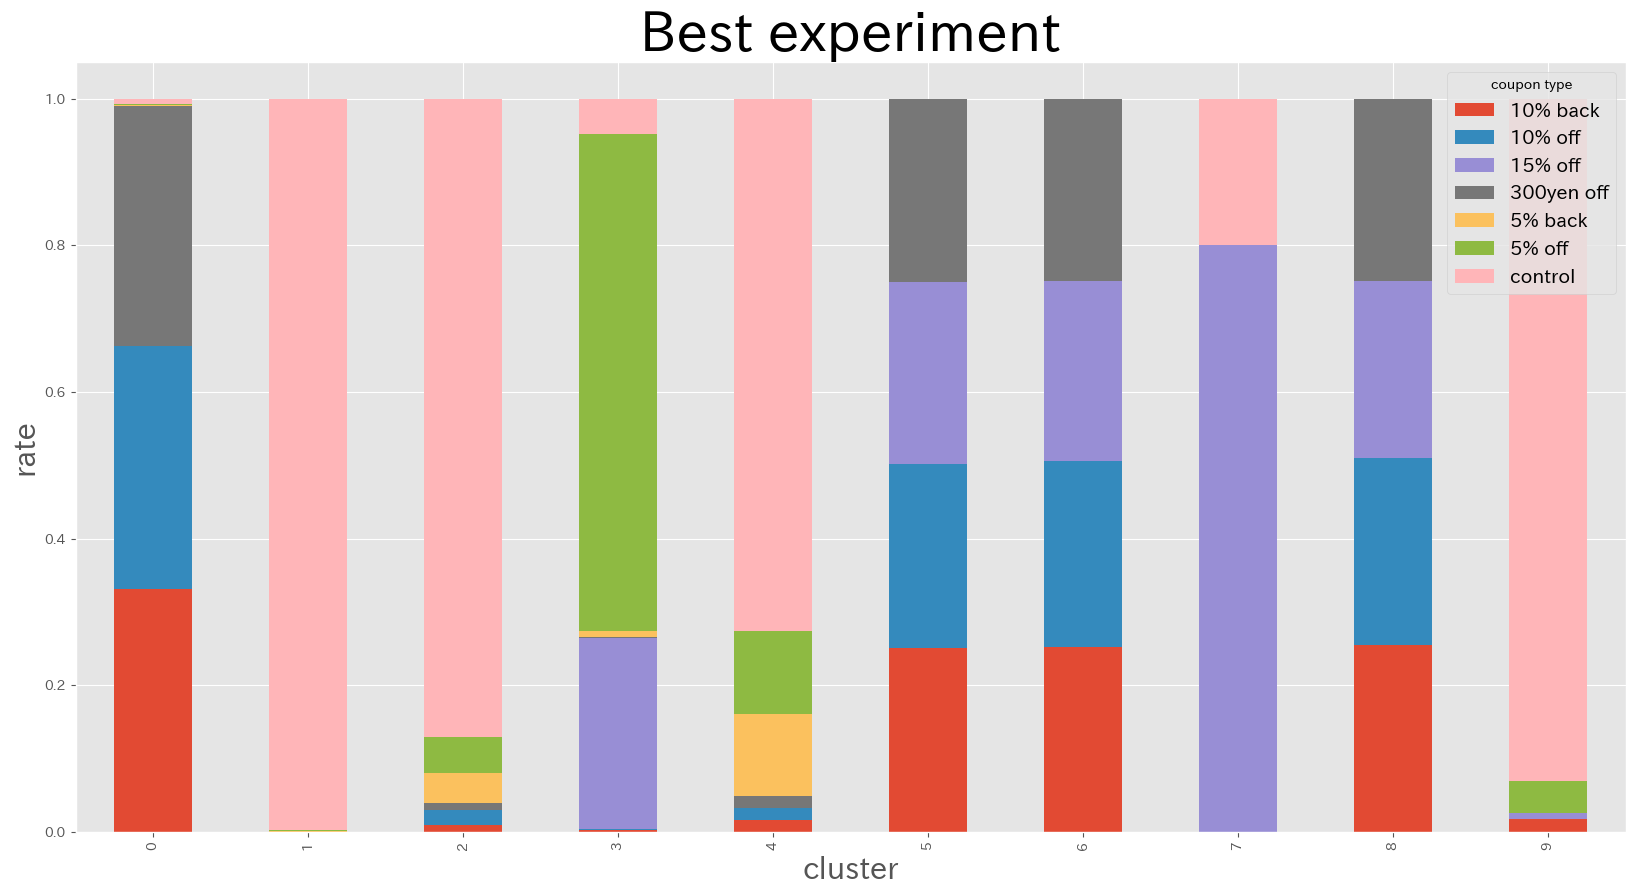

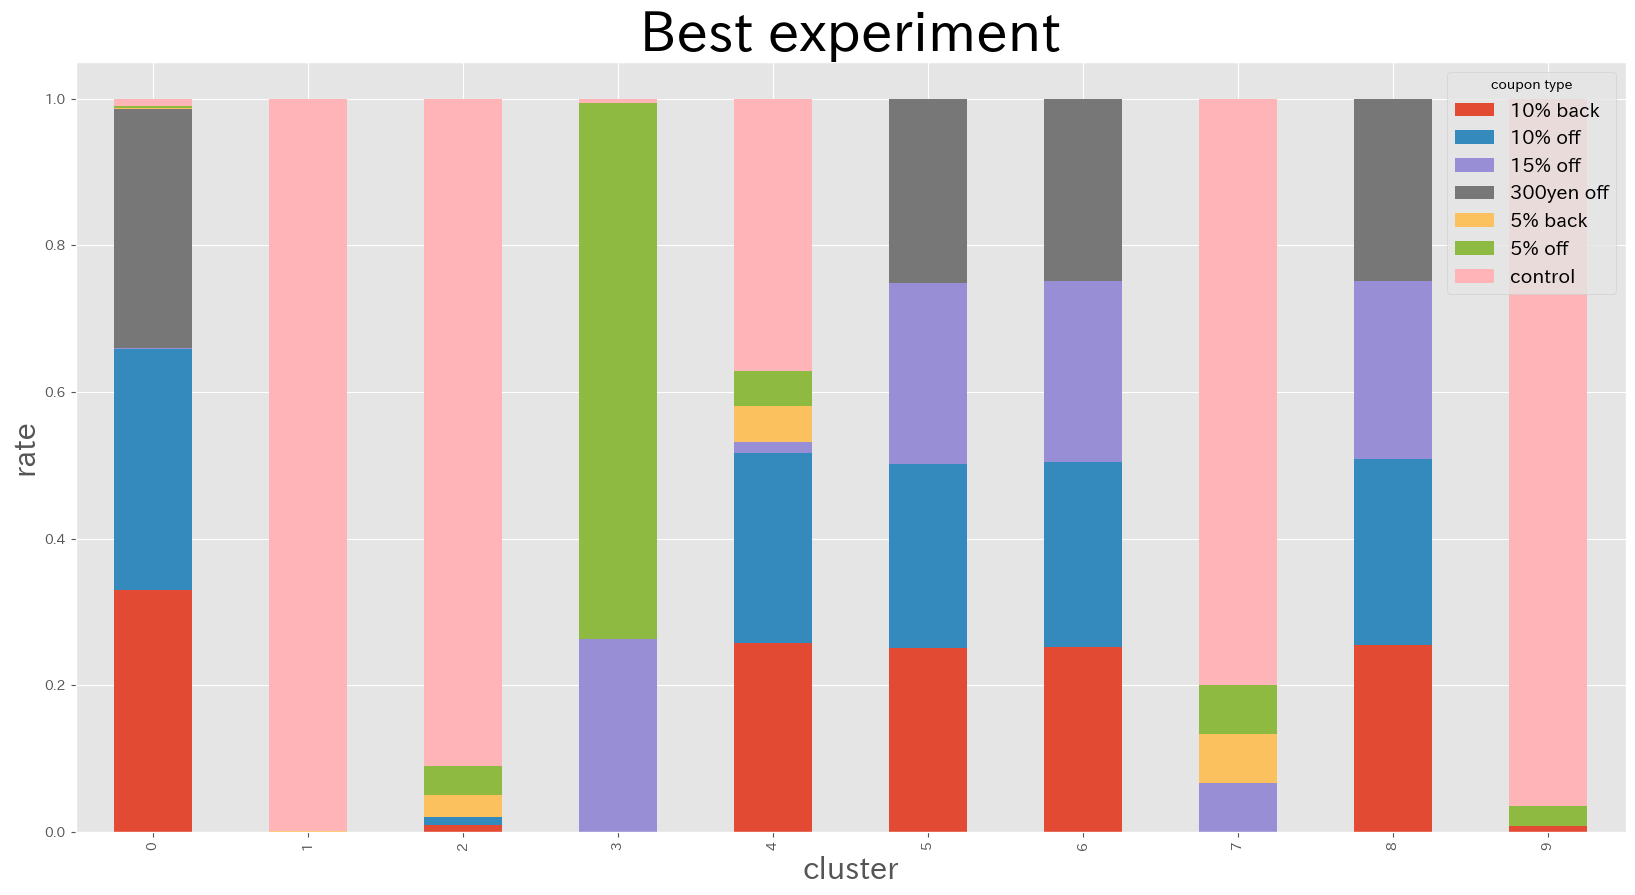

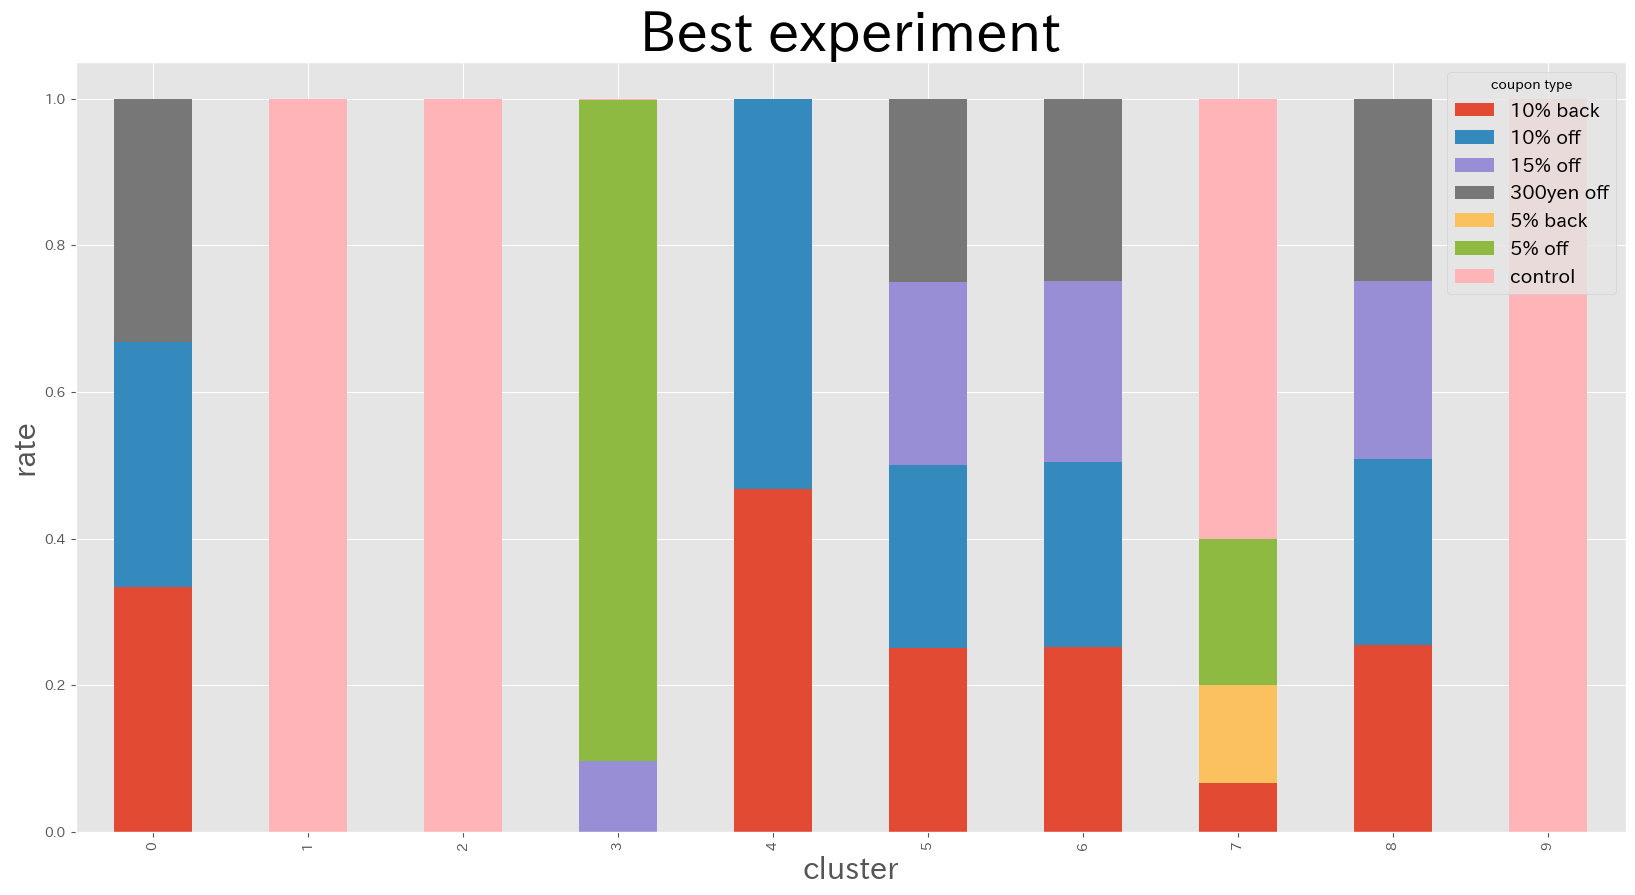

In [108]:
for i in range(10):
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    axes = [axes]
    cost = plot_assignment(top_exp_container, i, axes[0])
    axes[0].set_title('Best experiment', fontsize=40)
    axes[0].set_ylabel('rate', fontsize=22)
    axes[0].set_xlabel('cluster', fontsize=22)

    # cost = plot_assignment(bottom_exp_container, i, axes[1])
    # axes[1].set_title('Worst experiment', fontsize=40)
    # axes[1].set_ylabel('rate', fontsize=22)
    # axes[1].set_xlabel('cluster', fontsize=22)

    fig.savefig(str(dir_config.output_figure_dir / f'assignment{cost:.0}.png'))

In [9]:
agg_df = result_df.groupby('name')['GMV'].sum().reset_index()
agg_df[['alpha', 'cluster', 'gamma']] = split_name(agg_df['name'])
agg_df['rate'] = agg_df['gamma'] / (5 * agg_df['cluster'])

In [54]:
result_df[['alpha', 'cluster', 'gamma']] = split_name(result_df['name'])
result_df['beta'] = result_df['gamma'] / (5 * result_df['cluster'])

In [60]:
proposed = result_df.query('alpha == 0.6 and cluster == 10')
previous_name =  agg_df.query('alpha == 0').sort_values('GMV', ascending=False)['name'].values[0]
previous = result_df.query('name == @previous_name')

In [75]:
colors = list(plt.rcParams['axes.prop_cycle'] )
linestyles = ['-', '--', '-.', ':']

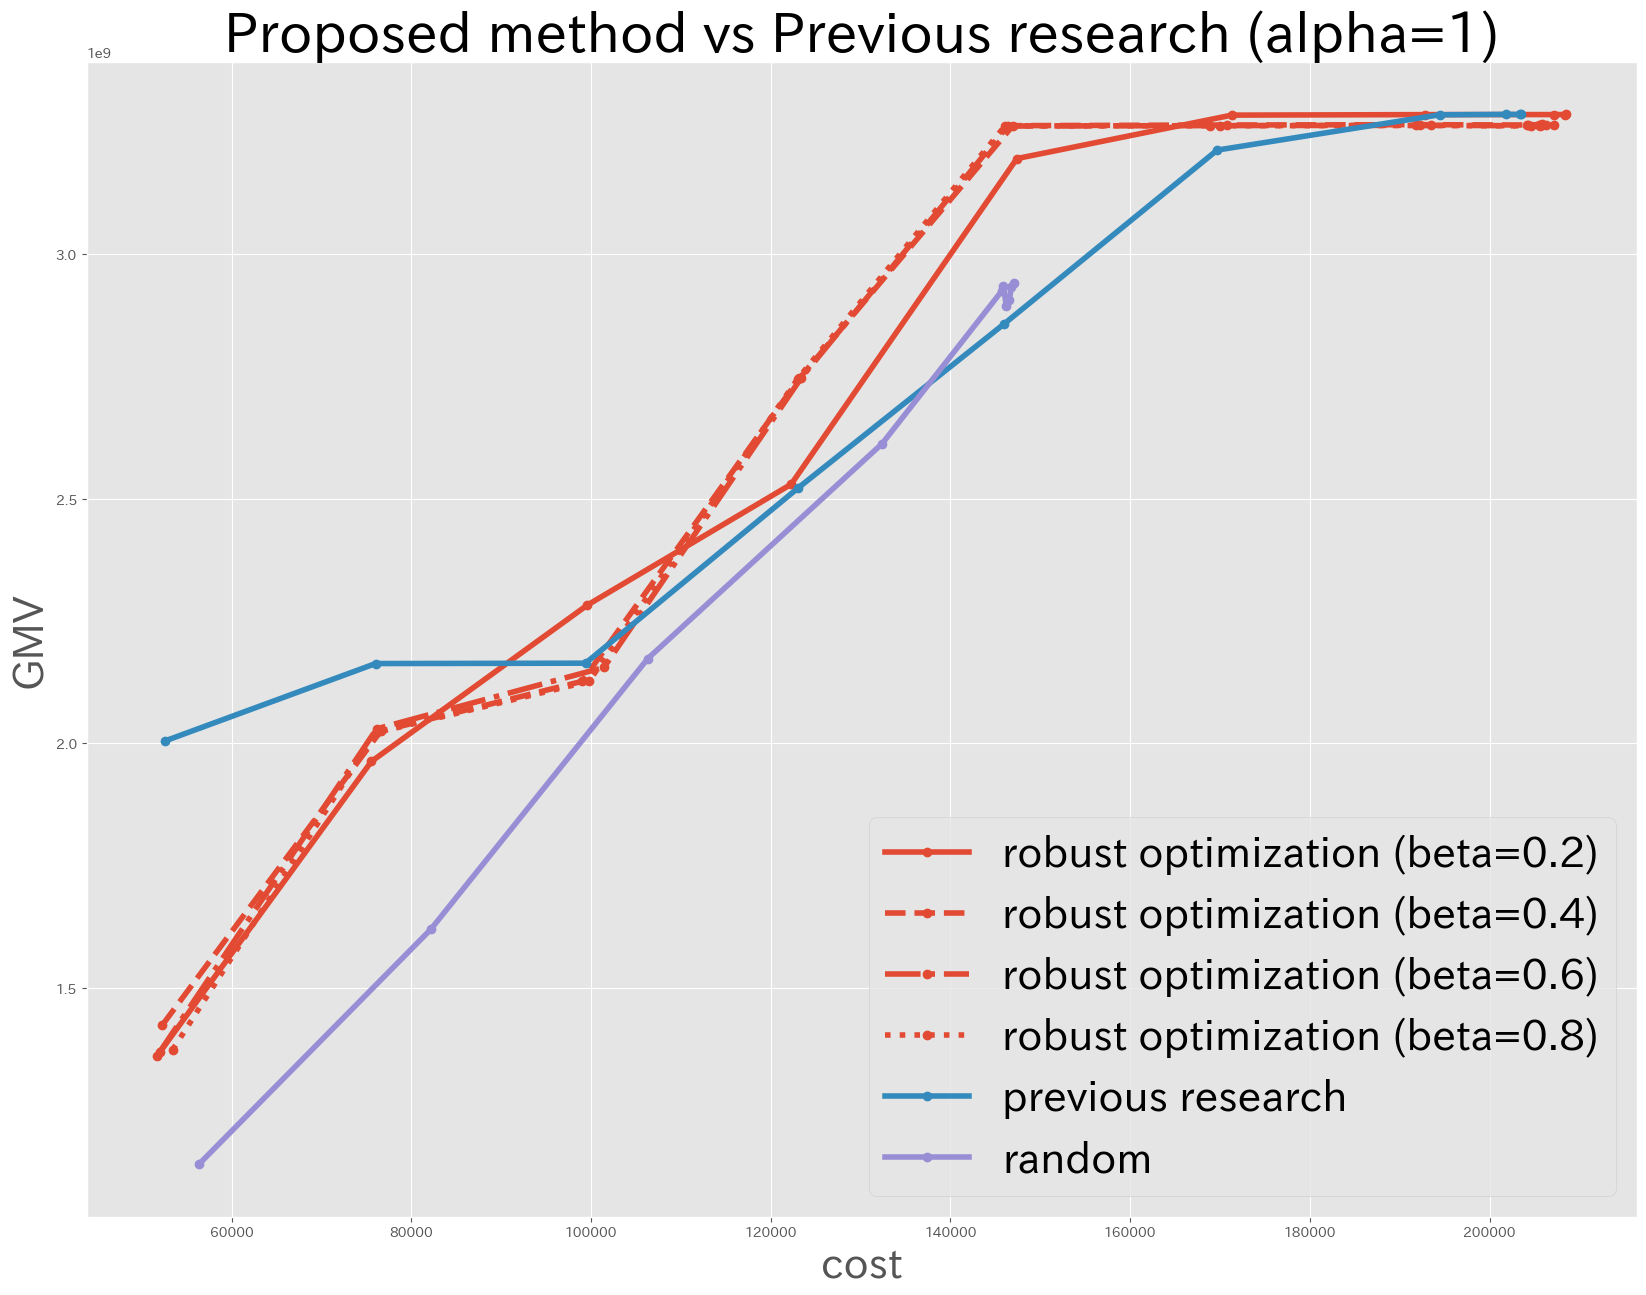

In [112]:
alpha = 1
proposed = result_df.query('alpha == @alpha and cluster == 10')
previous_name =  agg_df.query('alpha == 0').sort_values('GMV', ascending=False)['name'].values[0]
previous = result_df.query('name == @previous_name')

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
for i, name in enumerate(proposed['name'].unique()):
    _result_df = result_df.query('name == @name')
    beta = _result_df['beta'].unique()[0]
    ax.plot(_result_df['cost'], _result_df['GMV'], label=f'robust optimization (beta={beta:.2})', marker='o', linestyle=linestyles[i], color=colors[0]['color'], linewidth=4)

ax.plot(previous['cost'], previous['GMV'], alpha=1, linewidth=4, label='previous research', marker='o', color=colors[1]['color'])
ax.plot(random_results['cost'], random_results['GMV'], label='random', linewidth=4, marker='o', color=colors[2]['color'])
ax.set_xlabel('cost', fontsize=30)
ax.set_ylabel('GMV', fontsize=30)
ax.set_title(f'Proposed method vs Previous research (alpha={alpha})', fontsize=40)
ax.legend(fontsize=30)
fig.savefig(str(dir_config.output_figure_dir / f'vs_{alpha}.png'))

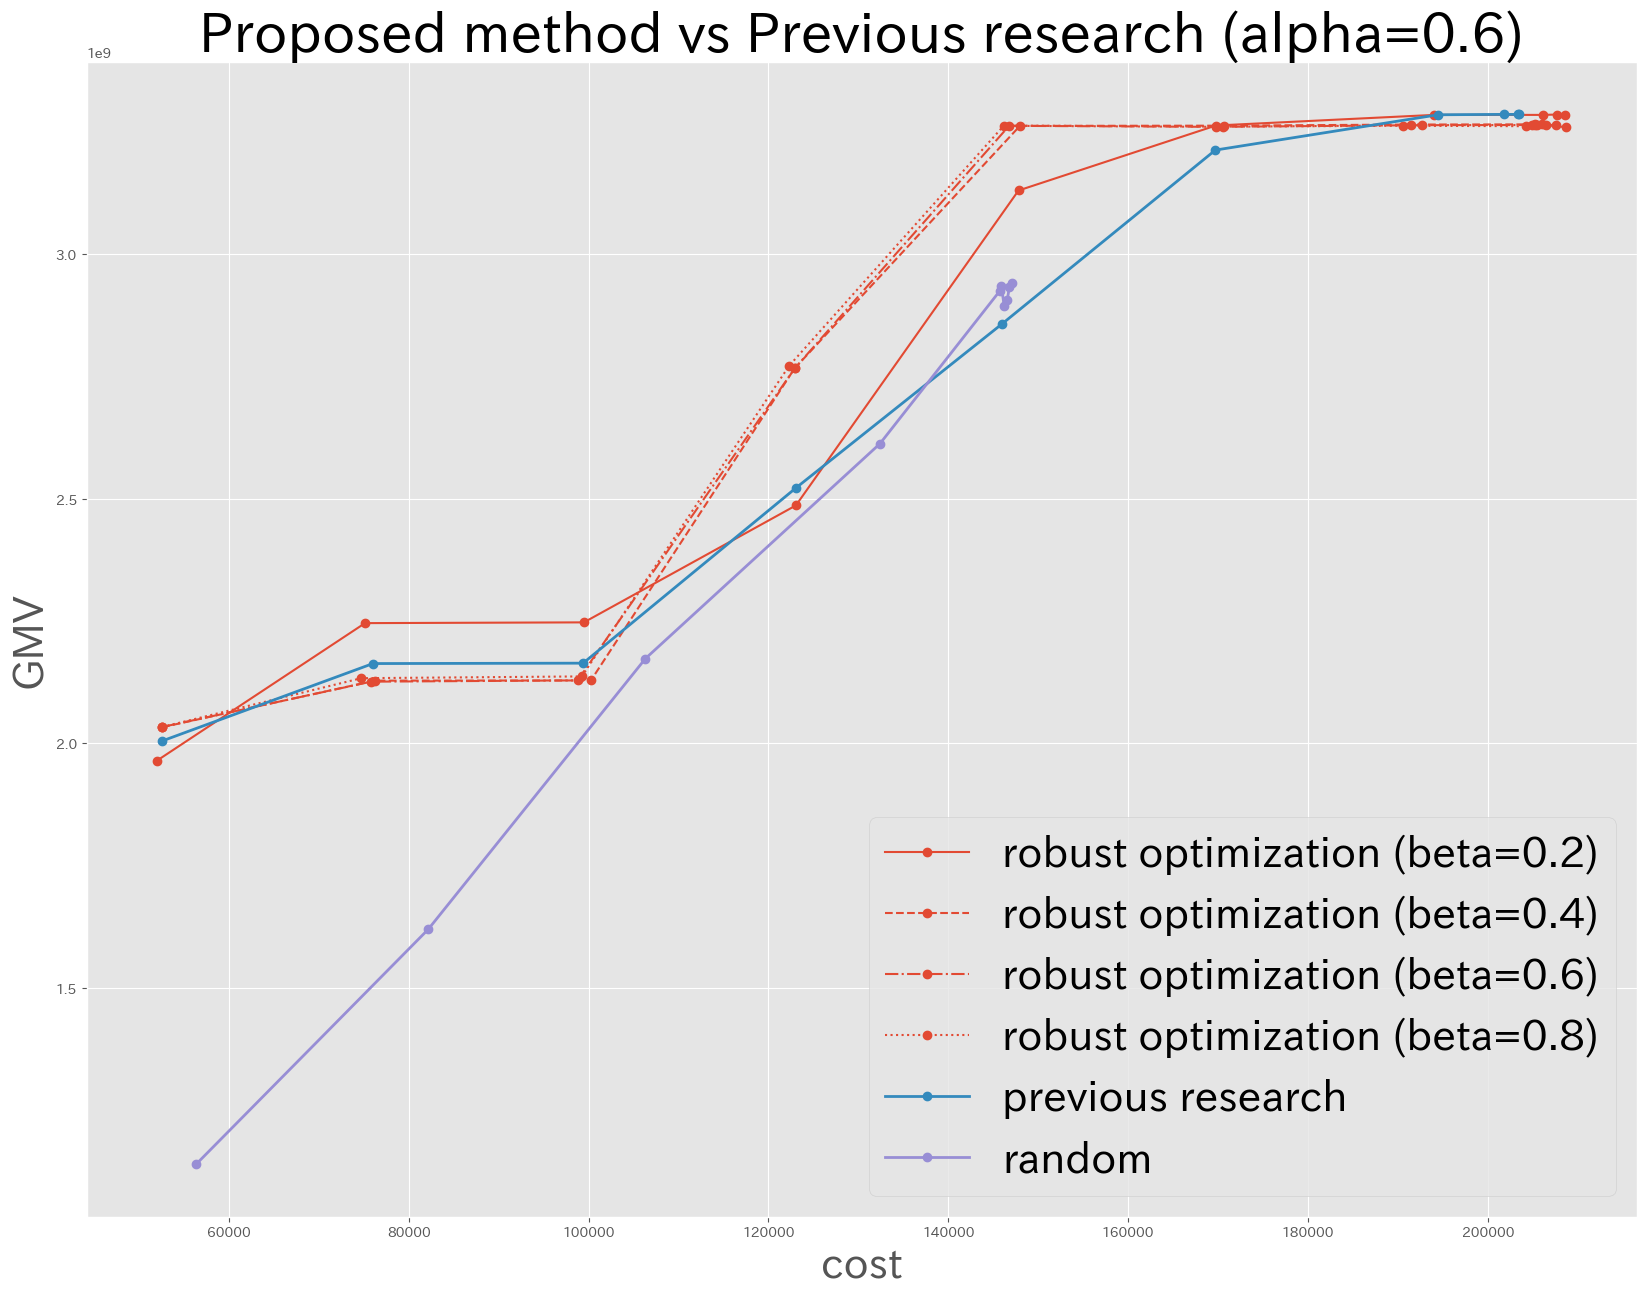

In [99]:
alpha = 0.6
proposed = result_df.query('alpha == @alpha and cluster == 10')
previous_name =  agg_df.query('alpha == 0').sort_values('GMV', ascending=False)['name'].values[0]
previous = result_df.query('name == @previous_name')

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
for i, name in enumerate(proposed['name'].unique()):
    _result_df = result_df.query('name == @name')
    beta = _result_df['beta'].unique()[0]
    if i == 0:
        ax.plot(_result_df['cost'], _result_df['GMV'], label=f'robust optimization (beta={beta:.2})', marker='o', linestyle=linestyles[i], color=colors[0]['color'])
    else:
        ax.plot(_result_df['cost'], _result_df['GMV'], label=f'robust optimization (beta={beta:.2})', marker='o', linestyle=linestyles[i], color=colors[0]['color'])

ax.plot(previous['cost'], previous['GMV'], alpha=1, linewidth=2, label='previous research', marker='o', color=colors[1]['color'])
ax.plot(random_results['cost'], random_results['GMV'], label='random', linewidth=2, marker='o', color=colors[2]['color'])
ax.set_xlabel('cost', fontsize=30)
ax.set_ylabel('GMV', fontsize=30)
ax.set_title(f'Proposed method vs Previous research (alpha={alpha})', fontsize=40)
ax.legend(fontsize=30)
fig.savefig(str(dir_config.output_figure_dir / f'vs_{alpha}.png'))

In [432]:
optimal = []
n = 10
for cost, gdf in result_df.groupby('cost'):
    gdf = gdf.sort_values('GMV', ascending=False)
    gdf['rate'] = gdf['gamma'] / (5 * gdf['cluster'])
    optimal.append(gdf[['cost', 'alpha', 'cluster', 'rate', 'GMV']].values[n])

optimal = pd.DataFrame(optimal, columns=['cost', 'alpha', 'cluster', 'gamma', 'GMV'])
optimal

,cost,alpha,cluster,gamma,GMV
0,396000.0,0.4,10.0,0.8,2.003997e+09
1,572000.0,0.6,10.0,0.8,2.133260e+09
2,748000.0,0.2,10.0,0.8,2.163838e+09
3,924000.0,1.0,10.0,0.4,2.746184e+09
4,1100000.0,1.0,10.0,0.6,3.261560e+09
5,1276000.0,0.6,10.0,0.2,3.262601e+09
6,1452000.0,0.6,1.0,0.4,3.417325e+09
7,1628000.0,0.6,1.0,0.4,3.417325e+09
8,1804000.0,0.4,1.0,0.6,3.417325e+09
9,1980000.0,0.6,1.0,0.4,3.417325e+09


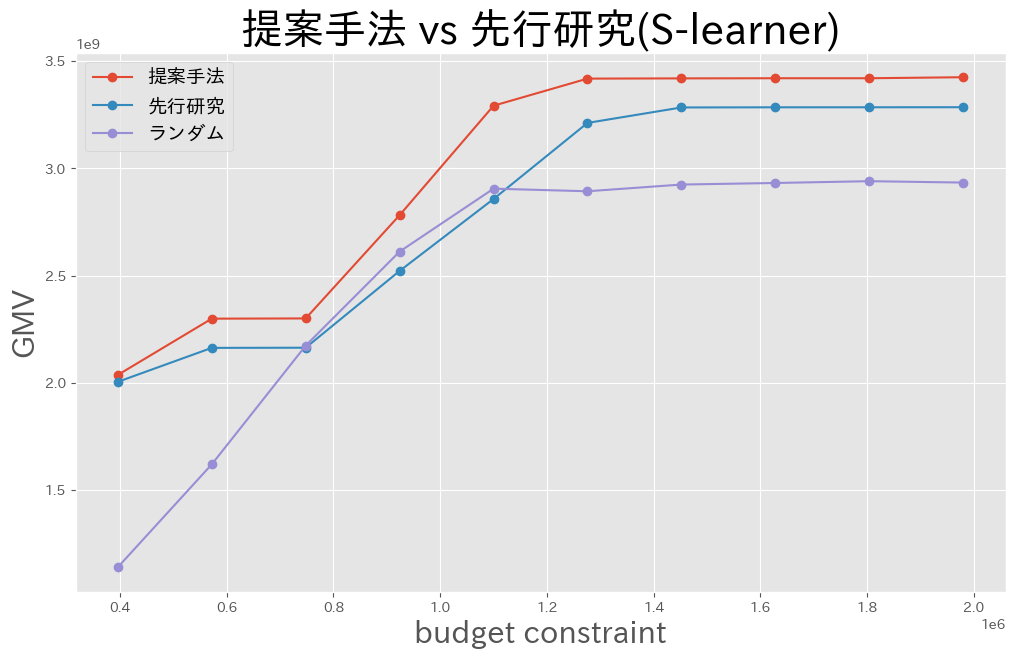

In [433]:
fig, ax = plt.subplots(figsize=(12, 7))

# proposed
ax.plot(
    proposed['cost'],
    proposed['GMV'],
    label='提案手法',
    marker='o',
)

# previous
ax.plot(
    previous['cost'],
    previous['GMV'],
    label='先行研究',
    marker='o',
)

# random
ax.plot(
    random_results['cost'],
    random_results['GMV'],
    label='ランダム',
    marker='o',
)

ax.legend(fontsize=14)
ax.set_xlabel('budget constraint', fontsize=22)
ax.set_ylabel('GMV', fontsize=22)
ax.set_title('提案手法 vs 先行研究(S-learner)', fontsize=30)

fig.savefig(str(dir_config.output_figure_dir / 'comparison.png'))

<AxesSubplot: xlabel='alpha', ylabel='rate'>

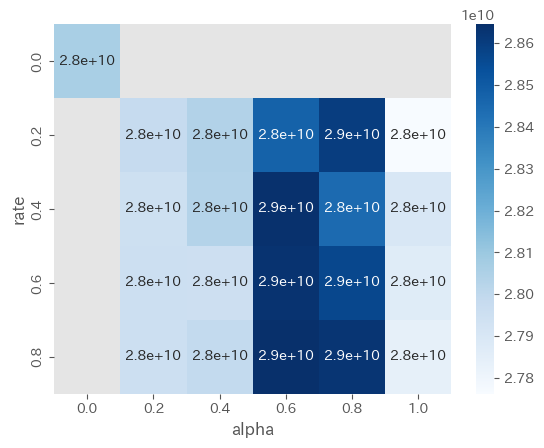

In [77]:
sns.heatmap(
    pd.pivot_table(
    agg_df.query('cluster == 10'),
    index='rate',
    columns='alpha',
    values='GMV',
    aggfunc='mean',
), 
annot=True, cmap='Blues')

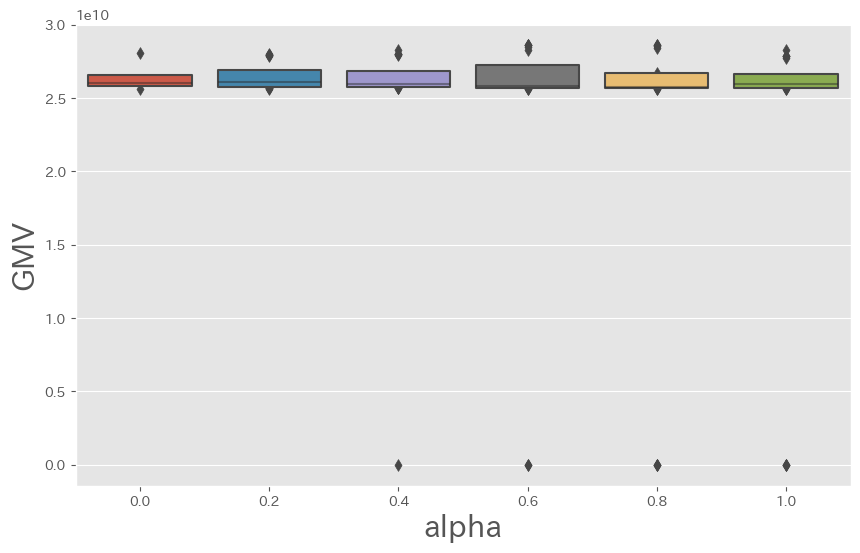

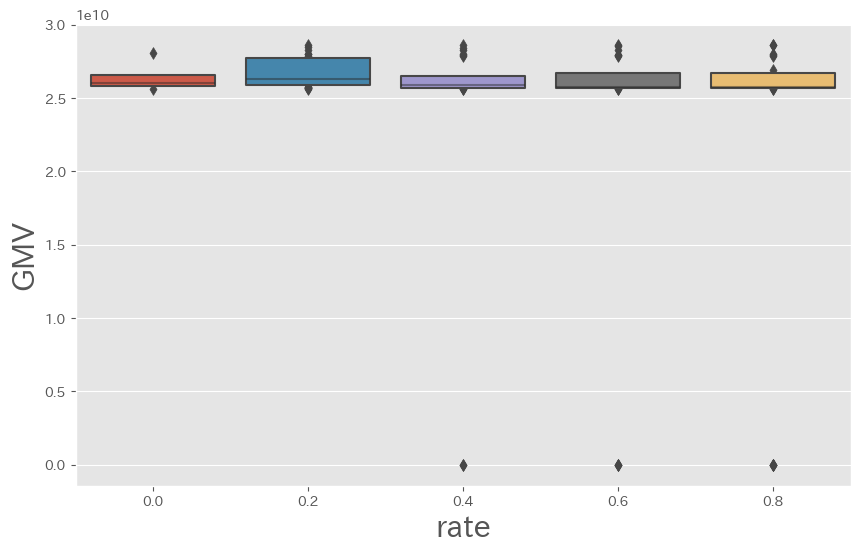

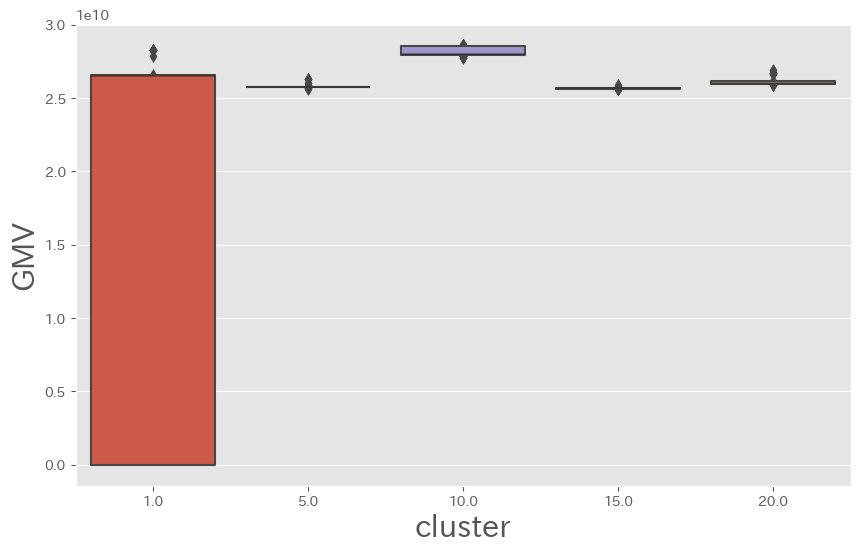

In [397]:
for i, col in enumerate(['alpha',  'rate', 'cluster']):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.boxenplot(data=agg_df, x=col, y='GMV', ax=ax)
    ax.set_xlabel(col, fontsize=22)
    ax.set_ylabel('GMV', fontsize=22)

    fig.savefig(str(dir_config.output_figure_dir / f'GMV_{col}.png'))